In [1]:
!pip install -q torch
!pip install -q darts
!pip install -q torchmetrics

In [2]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
import torch
import numpy as np
import pandas as pd
from darts import TimeSeries

In [3]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas


import openmeteo_requests

import requests_cache

from retry_requests import retry
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [4]:

def make_dataframe(openmeteo_response):

    hourly = openmeteo_response.Hourly()
    _start = pd.to_datetime(hourly.Time(), unit = "s", utc = True)
    _end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True)
    _delta = pd.Timedelta(seconds = hourly.Interval())

    data = {
        "date": pd.date_range(_start, _end, freq=_delta, inclusive="left"),
        "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
        "surface_pressure": hourly.Variables(1).ValuesAsNumpy(),
        "wind_speed_10m": hourly.Variables(2).ValuesAsNumpy(),
        "wind_direction_10m": hourly.Variables(3).ValuesAsNumpy(),
        "wind_gusts_10m": hourly.Variables(4).ValuesAsNumpy(),
    }

    return pd.DataFrame(data).set_index("date")

In [5]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [47.36, 46, 47.26, 46.5],
	"longitude": [8.55, 8.95, 11.39, 11.35],
	"start_date": "2024-02-10",
	"end_date": "2024-03-15",
	"hourly": ["temperature_2m", "surface_pressure", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"]
}
original_data = openmeteo.weather_api(url, params=params)
data = dict(zip(("Zurich", "Lugano", "Innsbruck", "Bolzano"), original_data))
data = pd.concat({key: make_dataframe(val) for key, val in data.items()})

city_codes = {"Zurich": 1, "Lugano": 2, "Innsbruck": 3, "Bolzano": 4}
data['city_code'] = data.index.get_level_values(0).map(city_codes)

In [6]:
original_data = dict(zip(("Zurich", "Lugano", "Innsbruck", "Bolzano"), original_data))
original_data = pd.concat({key: make_dataframe(val) for key, val in original_data.items()})

In [7]:
original_data.loc[('Zurich')]

,temperature_2m,surface_pressure,wind_speed_10m,wind_direction_10m,wind_gusts_10m
date,,,,,
2024-02-10 00:00:00+00:00,5.540000,942.989197,2.520000,180.000000,5.400000
2024-02-10 01:00:00+00:00,6.390000,942.373962,3.877318,158.198532,7.200000
2024-02-10 02:00:00+00:00,6.140000,941.570923,3.877318,111.801476,8.280000
2024-02-10 03:00:00+00:00,6.340000,941.034546,3.240000,90.000000,8.640000
2024-02-10 04:00:00+00:00,4.340000,940.217163,5.014219,68.962418,7.559999
...,...,...,...,...,...
2024-03-15 19:00:00+00:00,7.590000,967.487000,7.127636,224.999893,15.119999
2024-03-15 20:00:00+00:00,9.490001,968.099182,5.351785,227.726379,23.039999
2024-03-15 21:00:00+00:00,8.540000,967.936279,7.280550,188.530685,18.359999


In [8]:
correct = pd.DataFrame()

In [9]:
correct.index = original_data.loc[('Zurich')].index

In [10]:
correct['temperature_2m_zh'] = original_data.loc[('Zurich')].temperature_2m
correct['surface_pressure_zh'] = original_data.loc[('Zurich')].surface_pressure
correct['wind_speed_10m_zh'] = original_data.loc[('Zurich')].wind_speed_10m
correct['wind_direction_10m_zh'] = original_data.loc[('Zurich')].wind_direction_10m
correct['wind_gusts_10m_zh'] = original_data.loc[('Zurich')].wind_gusts_10m

correct['temperature_2m_lu'] = original_data.loc[('Lugano')].temperature_2m
correct['surface_pressure_lu'] = original_data.loc[('Lugano')].surface_pressure
correct['wind_speed_10m_lu'] = original_data.loc[('Lugano')].wind_speed_10m
correct['wind_direction_10m_lu'] = original_data.loc[('Lugano')].wind_direction_10m
correct['wind_gusts_10m_lu'] = original_data.loc[('Lugano')].wind_gusts_10m

correct['temperature_2m_in'] = original_data.loc[('Innsbruck')].temperature_2m
correct['surface_pressure_in'] = original_data.loc[('Innsbruck')].surface_pressure
correct['wind_speed_10m_in'] = original_data.loc[('Innsbruck')].wind_speed_10m
correct['wind_direction_10m_in'] = original_data.loc[('Innsbruck')].wind_direction_10m
correct['wind_gusts_10m_in'] = original_data.loc[('Innsbruck')].wind_gusts_10m

correct['temperature_2m_bo'] = original_data.loc[('Bolzano')].temperature_2m
correct['surface_pressure_bo'] = original_data.loc[('Bolzano')].surface_pressure
correct['wind_speed_10m_bo'] = original_data.loc[('Bolzano')].wind_speed_10m
correct['wind_direction_10m_bo'] = original_data.loc[('Bolzano')].wind_direction_10m
correct['wind_gusts_10m_bo'] = original_data.loc[('Bolzano')].wind_gusts_10m

In [11]:
correct

,temperature_2m_zh,surface_pressure_zh,wind_speed_10m_zh,wind_direction_10m_zh,wind_gusts_10m_zh,temperature_2m_lu,surface_pressure_lu,wind_speed_10m_lu,wind_direction_10m_lu,wind_gusts_10m_lu,temperature_2m_in,surface_pressure_in,wind_speed_10m_in,wind_direction_10m_in,wind_gusts_10m_in,temperature_2m_bo,surface_pressure_bo,wind_speed_10m_bo,wind_direction_10m_bo,wind_gusts_10m_bo
date,,,,,,,,,,,,,,,,,,,,
2024-02-10 00:00:00+00:00,5.540000,942.989197,2.520000,180.000000,5.400000,7.583,965.840881,3.219938,26.564985,11.52,6.5915,925.835388,6.034700,107.354111,40.680000,5.986500,965.391174,4.896529,342.897186,21.959999
2024-02-10 01:00:00+00:00,6.390000,942.373962,3.877318,158.198532,7.200000,7.683,965.755432,3.319036,12.528798,12.24,7.4915,925.764587,5.692100,108.435043,43.560001,8.836500,965.050232,2.811690,309.805511,24.480000
2024-02-10 02:00:00+00:00,6.140000,941.570923,3.877318,111.801476,8.280000,7.483,965.152222,2.414953,26.564985,11.52,7.4415,925.659912,5.804825,119.744789,42.839996,8.436501,965.196960,1.297998,303.690094,23.400000
2024-02-10 03:00:00+00:00,6.340000,941.034546,3.240000,90.000000,8.640000,7.383,964.560242,2.880000,360.000000,9.00,7.5415,925.776306,5.959060,115.016869,43.919998,8.186501,964.974426,2.414953,333.435028,21.240000
2024-02-10 04:00:00+00:00,4.340000,940.217163,5.014219,68.962418,7.559999,7.583,964.195679,2.545584,8.130019,9.00,7.7415,925.449707,5.804825,119.744789,44.279999,7.986500,964.757751,1.609969,333.435028,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 19:00:00+00:00,7.590000,967.487000,7.127636,224.999893,15.119999,12.233,985.817505,1.800000,90.000000,5.04,8.4415,949.750977,3.893995,146.309906,14.759999,14.636500,982.346619,2.902413,240.255203,16.199999
2024-03-15 20:00:00+00:00,9.490001,968.099182,5.351785,227.726379,23.039999,11.733,985.568359,1.835647,78.690102,5.04,8.7915,949.833313,3.096837,144.462234,15.840000,13.636500,982.812622,3.671294,191.309891,15.119999
2024-03-15 21:00:00+00:00,8.540000,967.936279,7.280550,188.530685,18.359999,9.733,985.440857,2.276840,71.564964,6.12,8.4915,949.576294,4.379589,9.462248,20.519999,12.786500,983.198181,2.189795,189.462250,15.119999


In [16]:
#Getting 'date' from the Multindex to be used in the future covariates

correct['dayofyear'] = correct.index.get_level_values('date').dayofyear

#sin and cos calculation 

correct['day_sin'] = np.sin(2 * np.pi * correct['dayofyear'] / 365.0)
correct['day_cos'] = np.cos(2 * np.pi * correct['dayofyear'] / 365.0)

In [25]:
originalindex = correct.index

In [27]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
target_scaler.fit(correct[['surface_pressure_zh']])
scaled_data = pd.DataFrame(scaler.fit_transform(correct), columns=scaler.get_feature_names_out())
scaled_data.index = originalindex

In [28]:
scaled_data

,temperature_2m_zh,surface_pressure_zh,wind_speed_10m_zh,wind_direction_10m_zh,wind_gusts_10m_zh,temperature_2m_lu,surface_pressure_lu,wind_speed_10m_lu,wind_direction_10m_lu,wind_gusts_10m_lu,...,wind_direction_10m_in,wind_gusts_10m_in,temperature_2m_bo,surface_pressure_bo,wind_speed_10m_bo,wind_direction_10m_bo,wind_gusts_10m_bo,dayofyear,day_sin,day_cos
date,,,,,,,,,,,,,,,,,,,,,
2024-02-10 00:00:00+00:00,0.405914,0.151528,0.108727,0.496359,0.056452,0.400602,0.158775,0.223537,0.069014,0.200000,...,0.291581,0.535519,0.338673,0.195064,0.533494,0.952188,0.434343,0.0,0.0,1.0
2024-02-10 01:00:00+00:00,0.451613,0.138723,0.167289,0.435358,0.096774,0.406627,0.156639,0.230417,0.029823,0.219048,...,0.294612,0.579235,0.469108,0.186687,0.306343,0.859678,0.505051,0.0,0.0,1.0
2024-02-10 02:00:00+00:00,0.438172,0.122010,0.167289,0.305539,0.120968,0.394578,0.141561,0.167653,0.069014,0.200000,...,0.326325,0.568306,0.450801,0.190292,0.141421,0.842582,0.474747,0.0,0.0,1.0
2024-02-10 03:00:00+00:00,0.448925,0.110847,0.139791,0.244539,0.129032,0.388554,0.126764,0.199938,1.000000,0.133333,...,0.313068,0.584699,0.439359,0.184824,0.263117,0.925736,0.414141,0.0,0.0,1.0
2024-02-10 04:00:00+00:00,0.341398,0.093835,0.216341,0.185675,0.104839,0.400602,0.117651,0.176721,0.017541,0.133333,...,0.326325,0.590164,0.430206,0.179501,0.175412,0.925736,0.323232,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 19:00:00+00:00,0.516129,0.661392,0.307525,0.622269,0.274194,0.680723,0.658117,0.124961,0.246131,0.028571,...,0.400813,0.142076,0.734554,0.611667,0.316228,0.665246,0.272727,1.0,1.0,0.0
2024-03-15 20:00:00+00:00,0.618280,0.674133,0.230905,0.629898,0.451613,0.650602,0.651890,0.127436,0.214553,0.028571,...,0.395632,0.158470,0.688787,0.623117,0.400000,0.528416,0.242424,1.0,1.0,0.0
2024-03-15 21:00:00+00:00,0.567204,0.670743,0.314123,0.520228,0.346774,0.530120,0.648703,0.158064,0.194658,0.057143,...,0.017093,0.229508,0.649886,0.632590,0.238586,0.523251,0.242424,1.0,1.0,0.0


In [29]:
target = scaled_data[['surface_pressure_zh']]
past_cov = scaled_data.drop(columns=['dayofyear', 'day_sin', 'day_cos'])
future_cov = scaled_data[['dayofyear', 'day_sin', 'day_cos']]

In [30]:
from darts import TimeSeries
from darts.models.forecasting.tft_model import TFTModel
from darts.metrics import mse
from darts.metrics import smape, mae
from torchmetrics.regression import MeanAbsoluteError

In [79]:
train_start = '2024-02-10 00:00:00+00:00'
train_end = '2024-03-03 23:00:00+00:00' #70% = 21 days
train_future_end ='2024-03-04 02:00:00+00:00'

val_start = '2024-03-04 00:00:00+00:00'
val_end = '2024-03-12 20:00:00+00:00' 
val_future_end = '2024-03-12 23:00:00+00:00'

test_start = '2024-03-13 00:00:00+00:00'
test_end = '2024-03-15 23:00:00+00:00'

y_train = target.loc[train_start:train_end]
past_cov_train = past_cov.loc[train_start:train_end]
future_cov_train = future_cov.loc[train_start:train_future_end]

y_val = target.loc[val_start:val_end]
past_cov_val = past_cov.loc[val_start:val_end]
future_cov_val = future_cov.loc[val_start:val_future_end]

y_test = target.loc[test_start:test_end]

y_train_backtest = target.loc[train_start:val_end]
past_cov_train_backtest = past_cov.loc[train_start:val_end]
future_cov_train_backtest = future_cov.loc[train_start:val_future_end]


In [80]:
y_train_series = TimeSeries.from_dataframe(y_train)
past_cov_train_series = TimeSeries.from_dataframe(past_cov_train)
future_cov_train_series = TimeSeries.from_dataframe(future_cov_train)

y_val_series = TimeSeries.from_dataframe(y_val)
past_cov_val_series = TimeSeries.from_dataframe(past_cov_val)
future_cov_val_series = TimeSeries.from_dataframe(future_cov_val)

y_test_series = TimeSeries.from_dataframe(y_test)

y_train_backtest_series = TimeSeries.from_dataframe(y_train_backtest)
past_cov_train_backtest_series = TimeSeries.from_dataframe(past_cov_train_backtest)
future_cov_train_backtest_series = TimeSeries.from_dataframe(future_cov_train_backtest)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the 

In [81]:
len(y_train_series)

552

In [82]:
# TFTModel:
input_chunk_length = 24
output_chunk_length = 3

In [89]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=100,
    min_delta=0.0001,
    mode='min',
)

# use GPU
pl_trainer_kwargs={"callbacks": [my_stopper],
                   "accelerator": "gpu",
                   "devices": [0]}

# use CPU
#pl_trainer_kwargs={"callbacks": [my_stopper],
                   #"accelerator": "cpu"}

# Advanced tuning
tft = TFTModel(input_chunk_length =input_chunk_length ,
               output_chunk_length = output_chunk_length,
               pl_trainer_kwargs = pl_trainer_kwargs,
               lstm_layers=2,
               num_attention_heads=8,
               dropout=0.2,
               batch_size=16,
               hidden_size=64,
               torch_metrics=MeanAbsoluteError(),
               n_epochs=200,
               # add_encoders=add_encoders
               )

tft.fit(series=y_train_series,
        past_covariates = past_cov_train_series,
        future_covariates = future_cov_train_series,
        val_series=y_val_series,
        val_past_covariates=past_cov_val_series,
        val_future_covariates=future_cov_val_series)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 47.3 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 5.2 K 
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
7  | static_context_hidden_encoder_grn | _GatedResid

Sanity Checking: |                                                                                | 0/? [00:00…

/home/elena/.pyenv/versions/3.10.6/envs/jawP_projectV2/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('val_MeanAbsoluteError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: |                                                                                       | 0/? [00:00…

/home/elena/.pyenv/versions/3.10.6/envs/jawP_projectV2/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('train_MeanAbsoluteError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=2, num_attention_heads=8, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.2, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=3, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f50d1e06710>], 'accelerator': 'gpu', 'devices': [0]}, batch_size=16, torch_metrics=MeanAbsoluteError(), n_epochs=100)

In [77]:
# Advanced tuning
# tft = TFTModel(input_chunk_length =input_chunk_length ,
#                output_chunk_length = output_chunk_length,
#                pl_trainer_kwargs = pl_trainer_kwargs,
#                lstm_layers=2,
#                num_attention_heads=8,
#                dropout=0.2,
#                batch_size=16,
#                hidden_size=64,
#                torch_metrics=MeanAbsoluteError(),
#                n_epochs=1000,
#                # add_encoders=add_encoders
#                )

##tft = TFTModel(input_chunk_length =input_chunk_length ,                
#               output_chunk_length = output_chunk_length,
#               pl_trainer_kwargs = pl_trainer_kwargs,
#               torch_metrics=MeanAbsoluteError(),
#               n_epochs=50
#               )

In [90]:
preds = tft.predict(n=output_chunk_length,
                   series=y_val_series,
                   past_covariates = past_cov_val_series,
                   future_covariates = future_cov_val_series)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

<Axes: xlabel='date'>

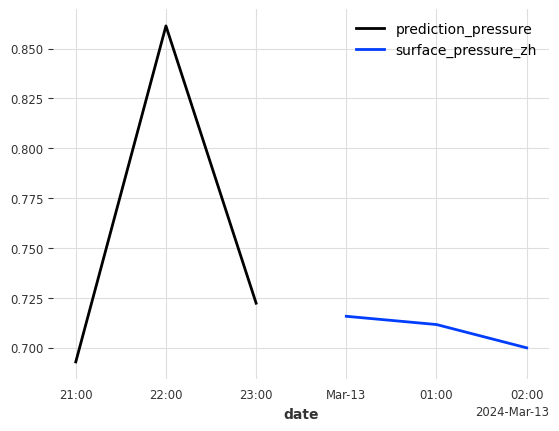

In [91]:
preds.plot(label='prediction_pressure')
y_test_series[:output_chunk_length].plot()

In [102]:
historical_fcast_tft = tft.historical_forecasts(
        series=y_train_backtest_series,
        past_covariates=past_cov_train_backtest_series,
        future_covariates=future_cov_train_backtest_series,
        start=0,
        forecast_horizon=7,
        verbose=False,
        retrain=False
)

`start` value `0` corresponding to timestamp `2024-02-10 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2024-02-11 00:00:00. To hide these warnings, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [103]:
historical_fcast_tft.duration,historical_fcast_tft.start_time(), historical_fcast_tft.end_time() 

(Timedelta('30 days 14:00:00'),
 Timestamp('2024-02-11 06:00:00'),
 Timestamp('2024-03-12 20:00:00'))

In [104]:
y_train_backtest_series.duration, y_train_backtest_series.start_time(), y_train_backtest_series.end_time()

(Timedelta('31 days 20:00:00'),
 Timestamp('2024-02-10 00:00:00'),
 Timestamp('2024-03-12 20:00:00'))

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

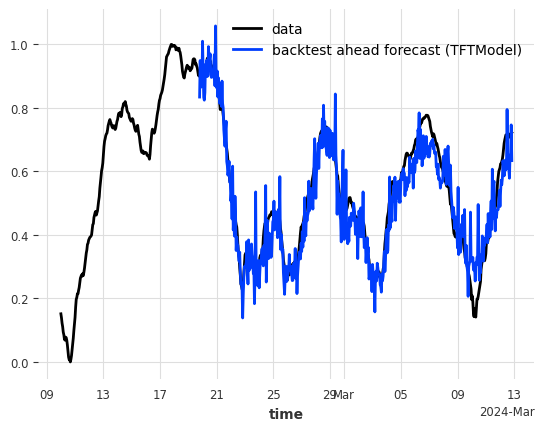

In [96]:
y_train_backtest_series.plot(label="data")
historical_fcast_tft.plot(low_quantile=0.01, high_quantile=0.99,label="backtest ahead forecast (TFTModel)")
print("SMAPE = {:.2f}%".format(smape(target_scaler.inverse_transform(historical_fcast_tft),target_scaler.inverse_transform(y_train_backtest_series))))
print("MAE = {:.2f}".format(mae(historical_fcast_tft, y_train_backtest_series)))

In [105]:
tft.save('tft_v1_1monthdata_3h')